## Machine Learning for Neuroscience, <br>Department of Brain Sciences, Faculty of Medicine, <br> Imperial College London
### Contributors: Alex Capstick, Francesca Palermo, Nan Fletcher-Lloyd, Yu Chen
**Spring 2024**

# Convolutional Neural Network (ConvNet/CNN)

Convolutional Neural Networks (ConvNet/CNN) are Deep Learning models that can take an input image, assign relevance (learnable weights and biases) to various aspects/objects in the image, and distinguish between them. <br />



<center><img src="./_dependents/rgb.png?raw=true" width="500" /></center>

You often see images divided into three colour planes — Red, Green, and Blue — RGB. <br />
But they can be stored in a variety of colour spaces, including Grayscale, RGB, HSV, CMYK, and others. <br />


With the basic machine learning techniques, it is required to hand-engineering features and analyse the figures dimension by dimension.
Imagine now taking a photo which exceeds 8K (7680x4320) dimensions and how computationally intensive it will be.
The ConvNet's job is to compress the images into a format that is easier to process while preserving elements that are important for obtaining a decent prediction. This is critical for designing an architecture that is capable of learning features while also being scalable to large datasets. So, while basic machine learning techniques require hand-engineering of features, ConvNets can learn these filters/characteristics through training.


Below an example of a CNN architecture for classification. Starting from a picture, it can pass the image through its layers and output the correct class of object present in the image (a car in this case).

<center><img src="./_dependents/basic_architecture.png?raw=true" width="800" /></center>


## Using PyTorch for creating a CNN architecture

In this experiment we will use the ```PyTorch``` library for creating our own CNN model.

First of all, let us import the necessary libraries with the following commands:

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  !git clone https://github.com/ML4NS/ml4ns.github.io
  from distutils.dir_util import copy_tree
  copy_tree("ml4ns.github.io/labs/07 - Convolutional Neural Networks (CNNs)/", "./")
  !pip install -r ml4ns.github.io/labs/requirements.txt

In [2]:
import torch # PyTorch is an open source machine learning framework.
import torch.nn as nn # nn package to build neural network layers
import torch.nn.functional as F # functional interface
import torch.utils.data as torchdata # package to load and process the data
# The torchvision package consists of popular datasets,
# model architectures, and common image transformations for computer vision.
import torchvision
from torchvision.transforms import v2 as transforms
import numpy as np # package to work with numbers
import os
from pandas.core.common import flatten
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as skmetrics
from sklearn import calibration as skcalibration

# class for holding the random state throughout the notebook.
# this keeps results consistent
class RandomState(object):
    def __init__(self, random_state=None):
        self.random_state = random_state
    def next(self, n=1):
        assert type(n) == int, "Ensure n is an integer"
        if n == 1:
            self.random_state,\
                out_state = np.random.default_rng(
                    self.random_state
                    ).integers(0, 1e9, size=(2,))
        else:
            self.random_state,\
                *out_state = np.random.default_rng(
                    self.random_state
                    ).integers(0, 1e9, size=(n+1,))

        return out_state

/home/alexcapstick/anaconda3/envs/ml4ns/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
random_state = RandomState(42)

In [4]:
torch.manual_seed(random_state.next())

We can create a ```device``` variable to check if a GPU is available.
If the output of device variable is 'cuda', then it means that PyTorch will use a GPU for the analysis. Otherwise, CPU is used instead.

In [5]:
# Device configuration
print('GPU available: {}' .format(torch.cuda.is_available()))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_on_gpu = torch.cuda.is_available()
device


GPU available: True


device(type='cuda')

## Load MRI Image Dataset

We will now load the  ```Alzheimer MRI Preprocessed Dataset``` dataset that we will use for the laboratory. For easier access, the dataset has already been downloaded and need to be unzip in a folder of your choice which will be called the ```dataset_path```. This dataset is made of around 6400 images of 128 x 128 pixels. For our analysis we have split the dataset into two classes: Dementia and Healthy.


Additional information on the dataset can be found [here](https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset)

We need to first unzip the archive file.

In [6]:
import shutil
# specificy the file to unpack and where to unpack it
shutil.unpack_archive('./data/MRI_database.zip', './data/')

We can then start load the data and creating the training, testing and validation datasets. This can be done easily with pytorch image folder if the files are organised in the following way:
    
```
dataset_path
    ├── class_1
        ├── image_1
        ...
        ├── image_n1
    ├── class_2
        ├── image_1
        ...
    ├── class_3
        ├── image_1
        ...
```

By default, this will load the images into `PIL.Image` format.

In [7]:
mri_dataset = torchvision.datasets.ImageFolder(
    root='./data/MRI_database',
    transform=None,
    target_transform=None,
)

In [8]:
print('Number of images: ', len(mri_dataset))
print('Number of classes: ', len(mri_dataset.classes))
print('Classes: ', mri_dataset.class_to_idx)


Number of images:  6400
Number of classes:  2
Classes:  {'0_Healthy': 0, '1_Dementia': 1}


Example of image with class label:  0
This image has size:  (128, 128)


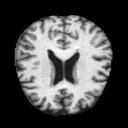

In [9]:
print("Example of image with class label: ", mri_dataset[0][1])
print("This image has size: ", mri_dataset[0][0].size)
mri_dataset[0][0]

However, for our purpose we would like to load the images as tensors, so that we can use machine learning models (such as a CNN) and normalise the data.

We do this by using the ```transforms.Compose``` function. This function allows us to chain together multiple transforms. We can then use the functions to convert the images into tensors and reshape them.

In [10]:
transform = transforms.Compose([
    transforms.ToImage(), # load as tensor in pytorch
    transforms.Grayscale(num_output_channels=1), # convert to grayscale with 1 channel
    transforms.Resize((32,32), antialias=False), # resize to 32x32 but without antialiasing
    transforms.ToDtype(torch.float32, scale=True), # convert to tensor to float32 and scale to [0,1]
])

mri_dataset = torchvision.datasets.ImageFolder(
    root='./data/MRI_database',
    transform=transform,
    target_transform=None,
)

We can see nothing has changed about our dataset, except that our images are now arrays rather than PIL images.

In [11]:
print('Number of images: ', len(mri_dataset))
print('Number of classes: ', len(mri_dataset.classes))
print('Classes: ', mri_dataset.class_to_idx)
print("Example of image with class label: ", mri_dataset[0][1])
print("This image has size: ", mri_dataset[0][0].shape)
mri_dataset[0][0]

Number of images:  6400
Number of classes:  2
Classes:  {'0_Healthy': 0, '1_Dementia': 1}
Example of image with class label:  0
This image has size:  torch.Size([1, 32, 32])


Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], )

We can now split our dataset into our training and testing:

In [12]:
test_size = int(0.2 * len(mri_dataset))

In [13]:
train_dataset, test_dataset = torchdata.random_split(
    mri_dataset, [len(mri_dataset) - test_size, test_size]
)

And we can get a validation set:

In [14]:
val_size = int(0.2 * len(train_dataset))

In [15]:
train_dataset, val_dataset = torchdata.random_split(
    mri_dataset, [len(mri_dataset) - val_size, val_size]
)

In [16]:
print(
    "The lengths of the train, validation, and test sets are:",
    f"{len(train_dataset)}, {len(val_dataset)}, {len(test_dataset)}"
)

The lengths of the train, validation, and test sets are: 5376, 1024, 1280


An example train image afer the resizing:

<Axes: title={'center': 'Class: 1'}>

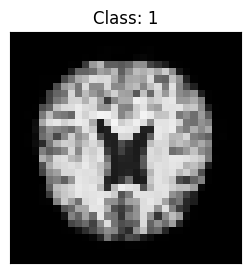

In [17]:
random_index = np.random.default_rng(random_state.next()).integers(0, len(train_dataset))

fig, ax = plt.subplots(1,1,figsize=(3, 3))

ax.imshow(train_dataset[random_index][0].squeeze(), cmap='gray', vmin=0, vmax=1)
ax.set_title(f"Class: {train_dataset[random_index][1]}")
ax.set_xticks([])
ax.set_yticks([])
ax

Recall, that our labels are:

In [18]:
print('Classes: ', mri_dataset.class_to_idx)

Classes:  {'0_Healthy': 0, '1_Dementia': 1}


## Preparing data with DataLoader

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we want to pass samples in “mini batches” and reshuffle the data at every epoch to reduce model overfitting.

```DataLoader``` is provided in PyTorch to automatically perform these functions.

For additional information on ```DataLoader```, you can refer to the [official documentation](https://pytorch.org/docs/stable/data.html)

Below we will load the dataset into DataLoader of batch_size=64 features and labels respectively

In [19]:
# first lets load it into memory to make things faster.
# If the dataset is too large, this is not a good idea
from dataset import MemoryDataset
train_dataset = MemoryDataset(train_dataset, now=False)

In [20]:
batch_size = 256

train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torchdata.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This is the shape of a single batch now:

In [21]:
x_batch, y_batch = next(iter(train_loader))

In [22]:
print("The shape of our batch of images is:", x_batch.shape)
print("The shape of our batch of labels is:", y_batch.shape)

The shape of our batch of images is: torch.Size([256, 1, 32, 32])
The shape of our batch of labels is: torch.Size([256])


We can use a handy torchvision function to visualise our data. This will show us a grid of images, with the corresponding labels.

In [23]:
image_grid = torchvision.utils.make_grid(x_batch, nrow=16)

<Axes: >

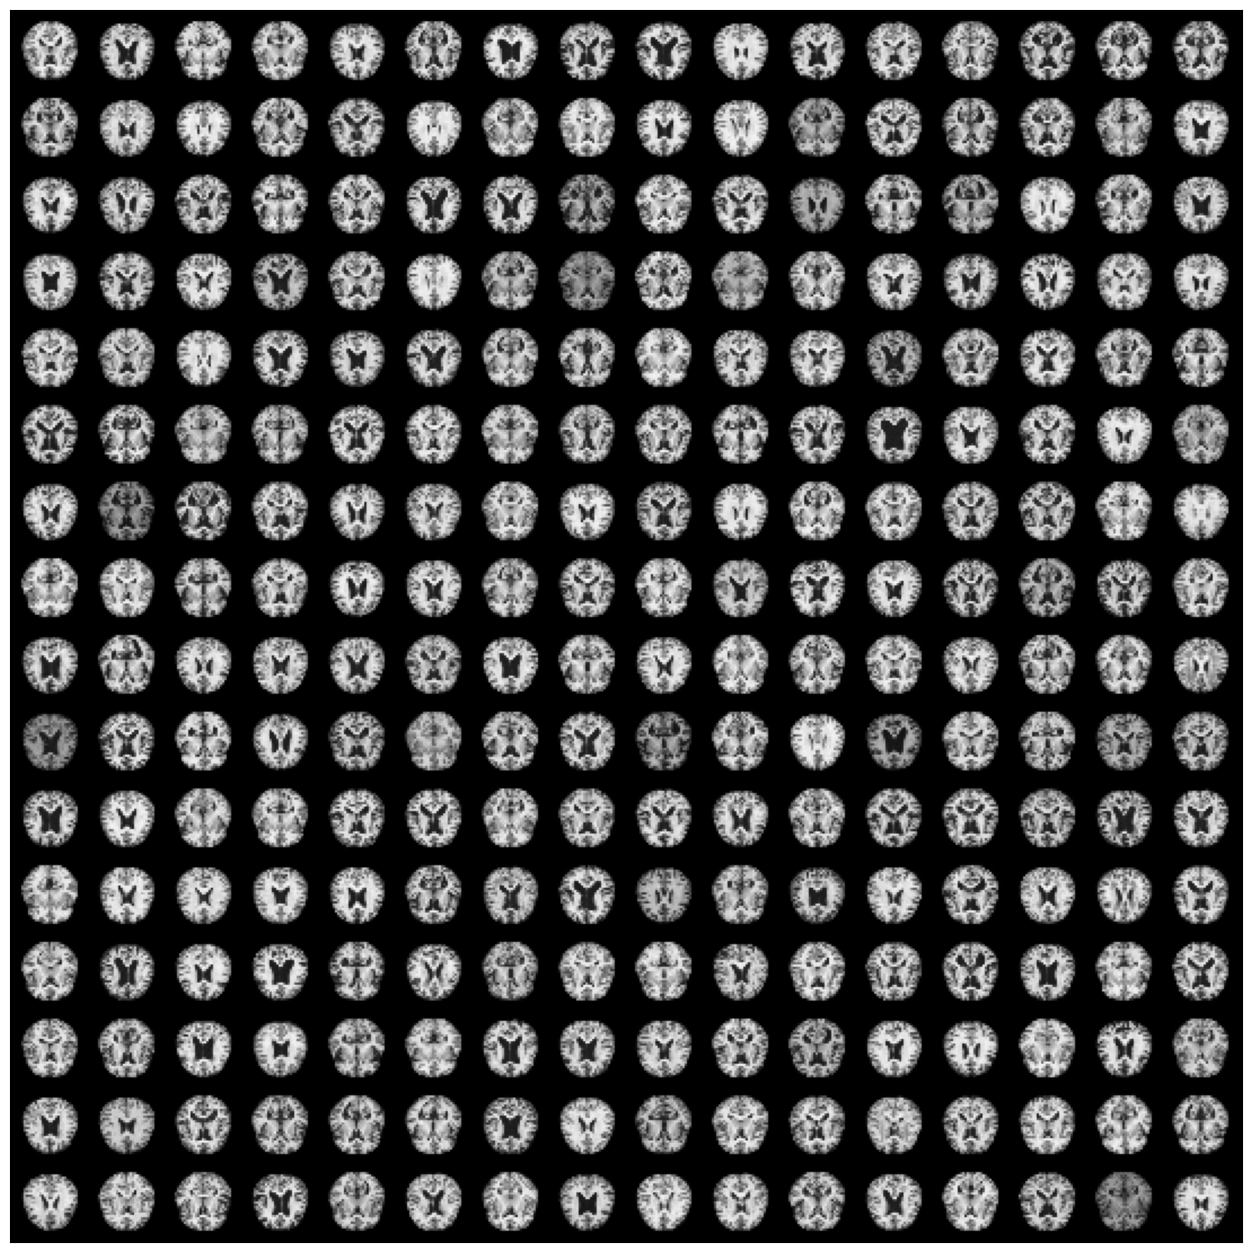

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,16))

ax.imshow(image_grid[0], cmap='gray', vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
ax

Additionally, we can also loop over our batch and plot the images individually:

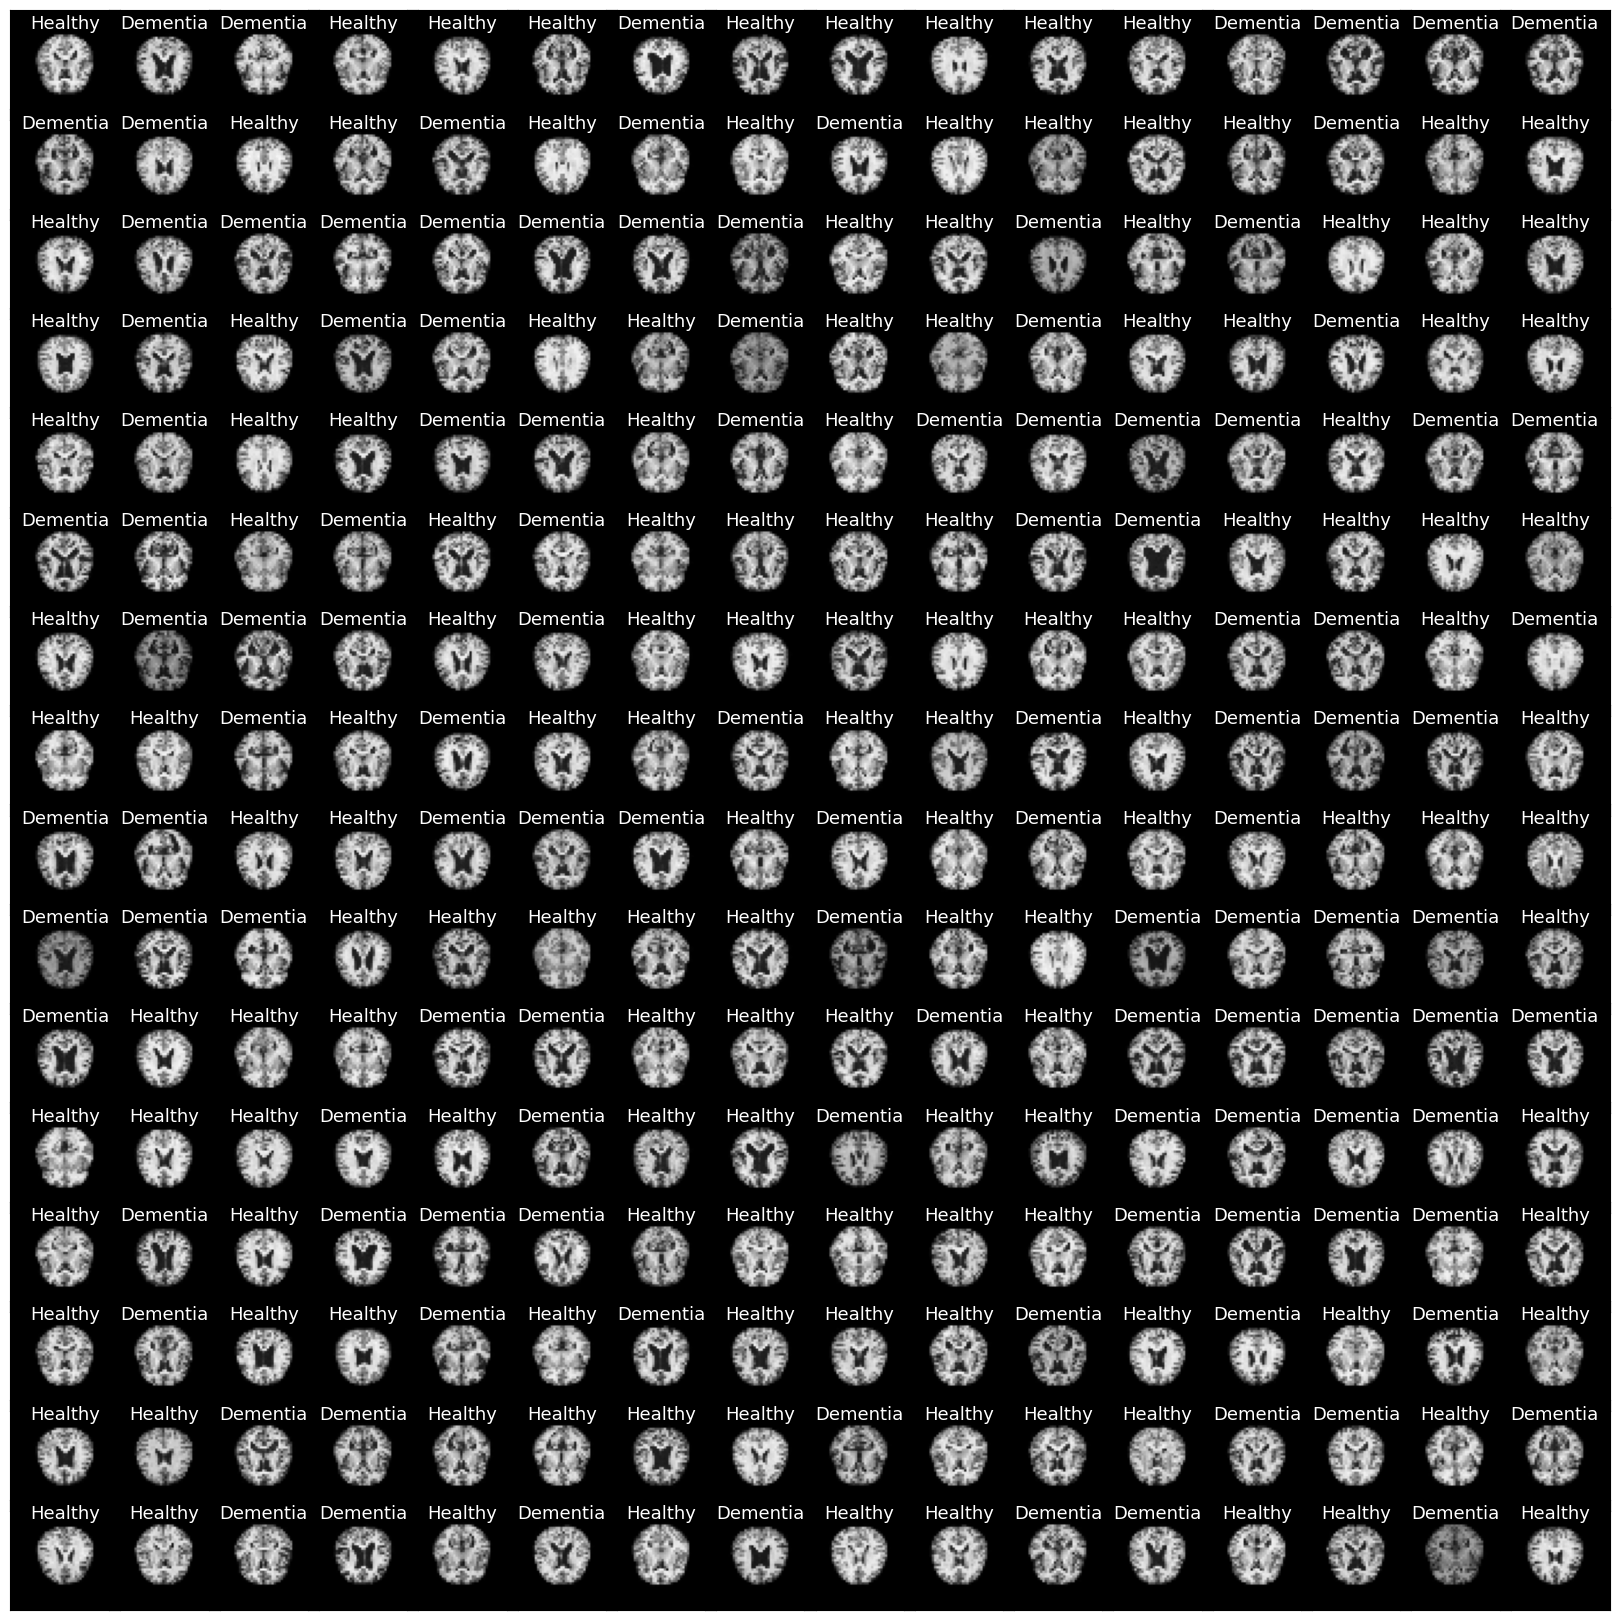

In [25]:
# {"Dementia": 0, "Healthy": 1} -> {0: "Dementia", 1: "Healthy"}
idx_to_class = {v:k for k, v in mri_dataset.class_to_idx.items()}
idx_to_class

# plotting the images
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(16,16)
for n, (image, target) in enumerate(zip(x_batch, y_batch)):
    ax = fig.add_subplot(gs[n])
    # adding padding for space for the label
    image = transforms.functional.pad(image, padding=(8,8,8,8))
    ax.imshow(image.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{idx_to_class[target.item()].split('_')[1]}", fontsize=13, fontdict={"color": "white"}, y=0.75)

plt.subplots_adjust(wspace=-0.1, hspace=-0.1, left=0, right=1.0, bottom=0, top=1.0)

We can see the augmentations that have been applied to our images. We hypothesise that this will help to prevent overfitting and improve the performance of our model.

## Create CNN Architecture

We will now create the architecture for the CNN. In this example we will use a similar architecture to VGG.

When creating the network, we also need to specify the activation function of each layer. We will use the Rectified Linear Units (ReLU) in this case.

If necessary, we can also introduce a regularisation layer to reduce possible overfitting. A simple way to do this can be to use dropout layers.

In [26]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=(1,1), padding=(1,1), bias=True):
        super(ConvBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=bias
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
    def forward(self, x):
        return self.net(x)


class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.5, bias=True):
        super(LinearBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, out_features, bias=bias),
            nn.ReLU(inplace=False),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

In [27]:
in_channels = 1
n_classes = 2

def cnn_s(in_channels, n_classes):
    return nn.Sequential(
        ConvBlock(in_channels, 64, (3,3), stride=(1,1), padding=(1,1)),
        ConvBlock(64, 128, (3,3), stride=(1,1), padding=(1,1)),
        ConvBlock(128, 256, (3,3), stride=(1,1), padding=(1,1)),
        ConvBlock(256, 256, (3,3), stride=(1,1), padding=(1,1)),
        #ConvBlock(256, 512, (3,3), stride=(1,1), padding=(1,1)),
        #ConvBlock(512, 512, (3,3), stride=(1,1), padding=(1,1)),
        #ConvBlock(512, 512, (3,3), stride=(1,1), padding=(1,1)),
        nn.AdaptiveAvgPool2d(output_size=(7, 7)),
        nn.Flatten(),
        LinearBlock(12544, 4096, dropout=0.25),
        LinearBlock(4096, 4096, dropout=0.25),
        LinearBlock(4096, 1000, dropout=0.25),
        # nn.Linear(4096, n_classes),
        # nn.Linear(4096, 1000),
        nn.Linear(1000, n_classes),
    )


# define the CNN architecture
cnn = cnn_s(in_channels, n_classes)
# move tensors to GPU if CUDA is available
if train_on_gpu:
    cnn.to(device=device)

Our model is as follows:

In [28]:
cnn

Sequential(
  (0): ConvBlock(
    (net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): ConvBlock(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): ConvBlock(
    (net): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (3): ConvBloc

This has the number of parameters:

In [29]:
n_params = 0
for name, param in cnn.named_parameters():
    n_params += param.numel()
print(f"Number of parameters: {n_params:,}")

Number of parameters: 73,225,786


## Define Loss and Optimser

**Loss**

Deep neural networks are trained via an algorithm called gradient descent.
It is necessary to repeatedly estimate the error for the model's current state as part of the optimisation method. To do this, we select a loss function that measures how good the model is at predicting the correct class given an image.

There exist multiple and different losses based on the scope of the analysis.
In this experiment, we are interested in classifying whether the image is of a dementia patient or a healthy individual. Our goal is to predict the probability of the sample belonging to each known class (either 0 or 1).

We can then use a loss called `Cross-entropy`, which should be minimised. This loss is commonly used in classification problems.


**Optimiser**

When training the model, we need to minimise the loss function and update the weights of the model at each epoch.
Here, the optimiser is the algorithm that modifies the weights of the neural network to reduce the loss and improve the overall accuracy.

There are various types of optimiser. In our case, we will use ```Adam``` which is one of the most popular gradient descent optimisation algorithms.

When setting up the optimiser, we also need to decide at which speed the model will learn. This is done via the learning rate.
It will tell the model how fast or slow we will move towards the optimal weights
<center><img src="./_dependents/learning_rate.png" width="300" /></center>

## Train the model

We have finally set up all the parameters and we can move on to train the model on our dataset.
We need to set the number of iterations that we want to train our model. This number needs to be carefully decided: if it is too low, then we risk of underfitting our model, if it is too high, we risk of overfitting it.
<center><img src="./_dependents/overfitting_model.png" width="300" /></center>

We will use a similar function as defined in the neural network lab. This can be found in the file `model_trainer.py`. We have edited this to include early stopping based on the validation loss and an option for a learning rate scheduler.

In [30]:
from model_trainer import train

In [31]:
n_classes = 2
in_channels = 1
n_epochs = 100

cnn = cnn_s(in_channels, n_classes)

criterion = torch.nn.CrossEntropyLoss()  # cross-entropy loss for classification
optimiser = torch.optim.Adam(cnn.parameters(), lr=0.001) # adam

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=n_epochs,
    eta_min=0.0002,
)

In [32]:
cnn, (train_loss_dict, val_loss_dict) = train(
    model=cnn,
    train_loader=train_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    val_loader=val_loader,
    patience=10,
    scheduler=scheduler,
)

Training on Epoch 1/100:   0%|          | 0/21 [00:00<?, ?it/s]

Training on Epoch 16/100: 100%|██████████| 21/21 [00:03<00:00,  6.48it/s, train_loss=0.19]

Stopping early...
Loading best model...


/tmp/ipykernel_2291/1282503570.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


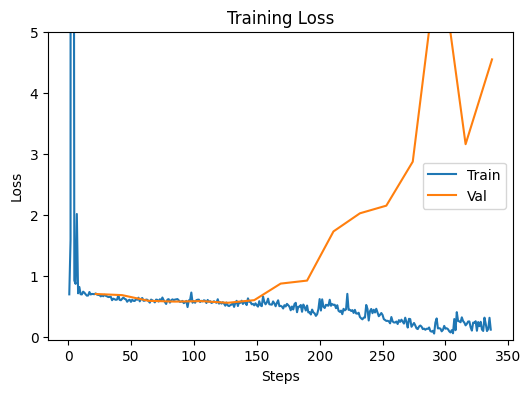

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot validation loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
ax.set_ylim(-0.05, 5)
# show plot
fig.show()

This looks like it didn't fit very well...

## Test the model

To test the model we will use the function that we have defined in the neural network lab. This can be found in the file `model_predictor.py`.

In [34]:
from model_predictor import predict

In [35]:
outputs, targets = predict(
    model=cnn,
    test_loader=test_loader,
)

Predicting:  20%|██        | 1/5 [00:00<00:00,  9.02it/s]

Predicting: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s]


In [36]:
y_pred = np.argmax(outputs.numpy(), axis=1)
y_proba = F.softmax(outputs, dim=1).numpy()
y_true = targets.numpy()

print("The accuracy of our model is:", skmetrics.accuracy_score(y_true, y_pred))
print("The precision of our model is:", skmetrics.precision_score(y_true, y_pred))
print("The recall of our model is:", skmetrics.recall_score(y_true, y_pred))
print("The f1 score of our model is:", skmetrics.f1_score(y_true, y_pred))

The accuracy of our model is: 0.7078125
The precision of our model is: 0.6565064478311841
The recall of our model is: 0.8736349453978159
The f1 score of our model is: 0.749665327978581


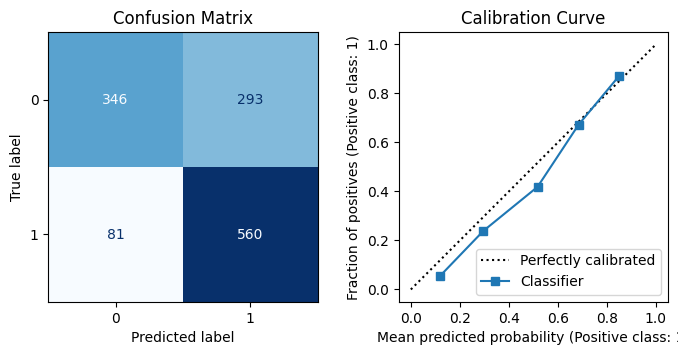

In [37]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
skmetrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Confusion Matrix")

ax2 = fig.add_subplot(gs[0,1])
skcalibration.CalibrationDisplay.from_predictions(
    y_true, y_proba[:,1], ax=ax2
)
ax2.set_title("Calibration Curve")
ax2.set_aspect('equal', adjustable='box')

fig.subplots_adjust(wspace=0.3)

In [38]:
del cnn

## Curious?

Things to try:
- Change the number of layers in the model (but check the input size of the first linear layer!)
- Change the learning rate
- Change the batch size
- Change the number of epochs
- Change the optimiser

## What if I Don't Know How to Design a Model Like This?

Then Pytorch has you covered! They have a few pretrained, and ready to use models that you can use for your own analysis. You can find them [here](https://pytorch.org/vision/stable/models.html). Let's try loading one of their Vision Transformer models, which are currently considered state of the art for image classification. This model is called uses a Convolution to encode the input to a vector that is processed by a transformer encoder.

In [39]:
# in pytorch it is almost too easy to get this model loaded:
vit = torchvision.models.vit_b_16(weights=None)

This model is slightly bigger than the cnn we just trained:

In [40]:
n_params = 0
for name, param in vit.named_parameters():
    n_params += param.numel()
print(f"Number of parameters: {n_params:,}")

Number of parameters: 86,567,656


Delete the vit to save RAM...

In [41]:
del vit

However, this model requires an image of at least 224 in height and width, so can't be applied to our MRI images.

Instead, we will load a resnet, which is a very popular CNN architecture. This model has been pretrained on ImageNet, which we will try and use to our advantage.

In [42]:
resnet = torchvision.models.resnet152(weights='DEFAULT')

In [43]:
n_params = 0
for name, param in resnet.named_parameters():
    n_params += param.numel()
print(f"Number of parameters: {n_params:,}")

Number of parameters: 60,192,808


In [44]:
x_batch, y_batch = next(iter(train_loader))

Since this model expects a 3 channel image, we will need to add a dimension to our images. We can either do this by repeating the image in the channel dimension, or by using a convolution. For fun, lets do the latter:

In [45]:
resnet = nn.Sequential(
    nn.Conv2d(1, 3, (3,3), stride=(1,1), padding=(1,1)),
    resnet,
)

Output shape:

In [46]:
resnet(x_batch).shape

torch.Size([256, 1000])

We can see that it also outputs to 1000 classes, which is the number of classes in ImageNet. We will need to change this to 2, which is the number of classes in our dataset.

In [47]:
resnet = nn.Sequential(
    resnet,
    nn.Linear(1000, 2),
)

Output shape:

In [48]:
resnet(x_batch).shape

torch.Size([256, 2])

Great! Let's make a function that when called loads this model:

In [49]:
def resnet_s(in_channels, n_classes):
    return nn.Sequential(
        nn.Conv2d(in_channels, 3, (3,3), stride=(1,1), padding=(1,1)),
        torchvision.models.resnet152(weights='DEFAULT'),
        nn.Linear(1000, n_classes),
    )

Now we can train the whole model as before and make use of the pretrained weights.

In [50]:
from collections import OrderedDict

def resnet_s_pretrained(in_channels, n_classes):
    channel_expander = nn.Conv2d(in_channels, 3, (3,3), stride=(1,1), padding=(1,1))
    pretrained_resnet = torchvision.models.resnet152(weights='DEFAULT')

    classifier = nn.Sequential(
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, n_classes),
    )

    return nn.Sequential(
        # ordered dict allows us to name the layers
        OrderedDict({
            'channel_expander': channel_expander,
            'pretrained_resnet': pretrained_resnet,
            'classifier': classifier,
        })
    )

In [51]:
n_classes = 2
in_channels = 1
n_epochs = 100

resnet = resnet_s_pretrained(in_channels, n_classes)

criterion = torch.nn.CrossEntropyLoss()  # cross-entropy loss for classification
optimiser = torch.optim.Adam(
    resnet.parameters(),
    lr=0.001
) # adam

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=n_epochs,
    eta_min=0.0002,
)

In [52]:
n_params = 0
for name, param in resnet.named_parameters():
    n_params += param.numel()
print(f"Number of parameters: {n_params:,}")

Number of parameters: 61,195,840


Great! Let's try training this...

In [53]:
from model_trainer import train

In [54]:
resnet, (train_loss_dict, val_loss_dict) = train(
    model=resnet,
    train_loader=train_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    val_loader=val_loader,
    patience=10,
    scheduler=scheduler,
)

Training on Epoch 1/100:  14%|█▍        | 3/21 [00:00<00:04,  3.68it/s]

Training on Epoch 25/100: 100%|██████████| 21/21 [00:04<00:00,  4.60it/s, train_loss=0.00883]

Stopping early...
Loading best model...


/tmp/ipykernel_2291/4264778314.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


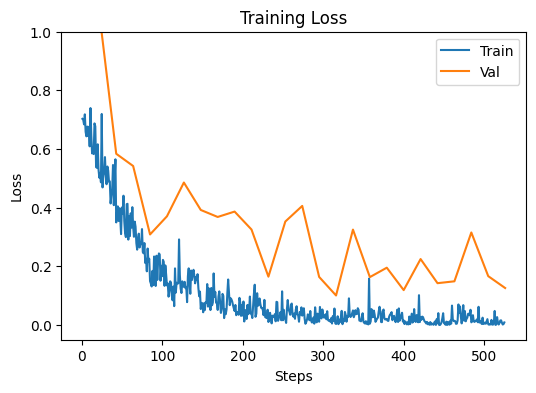

In [55]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot validation loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
ax.set_ylim(-0.05, 1)
# show plot
fig.show()

In [56]:
from model_predictor import predict

In [57]:
outputs, targets = predict(
    model=resnet,
    test_loader=test_loader,
)

Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

Predicting: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


In [58]:
y_pred = np.argmax(outputs.numpy(), axis=1)
y_proba = F.softmax(outputs, dim=1).numpy()
y_true = targets.numpy()

print("The accuracy of our model is:", skmetrics.accuracy_score(y_true, y_pred))
print("The precision of our model is:", skmetrics.precision_score(y_true, y_pred))
print("The recall of our model is:", skmetrics.recall_score(y_true, y_pred))
print("The f1 score of our model is:", skmetrics.f1_score(y_true, y_pred))

The accuracy of our model is: 0.9921875
The precision of our model is: 0.9921996879875195
The recall of our model is: 0.9921996879875195
The f1 score of our model is: 0.9921996879875195


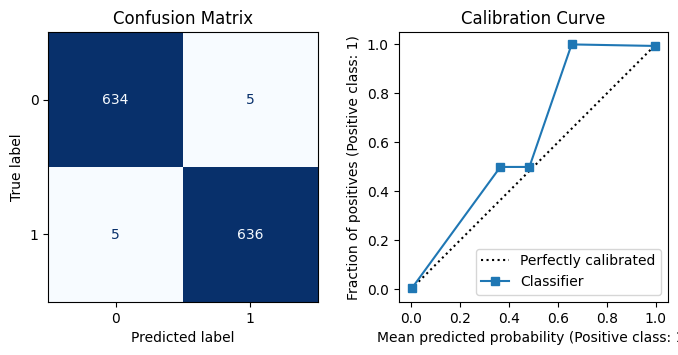

In [59]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
skmetrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Confusion Matrix")

ax2 = fig.add_subplot(gs[0,1])
skcalibration.CalibrationDisplay.from_predictions(
    y_true, y_proba[:,1], ax=ax2
)
ax2.set_title("Calibration Curve")
ax2.set_aspect('equal', adjustable='box')

fig.subplots_adjust(wspace=0.3)

In [60]:
del resnet

## Are Other Models Available?

Yes! We can also use hugging face to explore available models (and not just vision models!): https://huggingface.co/models?pipeline_tag=image-classification&sort=trending

In [61]:
from transformers import ConvNextForImageClassification

In [62]:
# model
convnext = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

In [63]:
del convnext

We can put these models into a `nn.Module` that will create our final model.

In [64]:
class ConvNext(nn.Module):
    def __init__(self, in_channels, n_classes) -> None:
        super().__init__()
        
        # this pretrained model requires three channels
        self.channel_expander = nn.Conv2d(in_channels, 3, (3,3), stride=(1,1), padding=(1,1))
        self.convnext = ConvNextForImageClassification.from_pretrained(
           "facebook/convnext-tiny-224"
        )
        self.classifier = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1000, n_classes),
        )

    def forward(self, x):
        x = self.channel_expander(x)
        x = self.convnext(x).logits
        x = self.classifier(x)
        return x


In [65]:
n_classes = 2
in_channels = 1
n_epochs = 100

convnext = ConvNext(in_channels, n_classes)

criterion = torch.nn.CrossEntropyLoss()  # cross-entropy loss for classification
optimiser = torch.optim.SGD(
    convnext.parameters(),
    lr=0.01
) # adam didn't work well here but SGD did...

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimiser,
    T_max=n_epochs,
    eta_min=0.0002,
)

In [66]:
n_params = 0
for name, param in convnext.named_parameters():
    n_params += param.numel()
print(f"Number of parameters: {n_params:,}")

Number of parameters: 29,592,160


In [67]:
from model_trainer import train

In [68]:
x_batch, y_batch = next(iter(train_loader))

In [69]:
convnext, (train_loss_dict, val_loss_dict) = train(
    model=convnext,
    train_loader=train_loader,
    n_epochs=n_epochs,
    optimiser=optimiser,
    criterion=criterion,
    val_loader=val_loader,
    patience=10,
    scheduler=scheduler,
)

Training on Epoch 1/100:   0%|          | 0/21 [00:00<?, ?it/s]

Training on Epoch 58/100: 100%|██████████| 21/21 [00:03<00:00,  6.56it/s, train_loss=0.00315]

Stopping early...
Loading best model...


/tmp/ipykernel_2291/4264778314.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


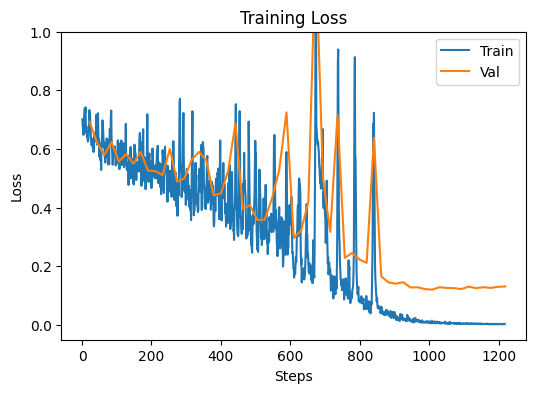

In [70]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) # plotting area

# plot training loss
ax.plot(
    train_loss_dict['step'], train_loss_dict['loss'],
    label='Train'
    )

# plot validation loss
ax.plot(
    val_loss_dict['step'], val_loss_dict['loss'],
    label='Val'
    )

# formatting
ax.set_title('Training Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Steps')
ax.legend()
ax.set_ylim(-0.05, 1)
# show plot
fig.show()

In [71]:
from model_predictor import predict

In [72]:
outputs, targets = predict(
    model=convnext,
    test_loader=test_loader,
)

Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

Predicting: 100%|██████████| 5/5 [00:00<00:00,  9.13it/s]


In [73]:
y_pred = np.argmax(outputs.numpy(), axis=1)
y_proba = F.softmax(outputs, dim=1).numpy()
y_true = targets.numpy()

print("The accuracy of our model is:", skmetrics.accuracy_score(y_true, y_pred))
print("The precision of our model is:", skmetrics.precision_score(y_true, y_pred))
print("The recall of our model is:", skmetrics.recall_score(y_true, y_pred))
print("The f1 score of our model is:", skmetrics.f1_score(y_true, y_pred))

The accuracy of our model is: 0.99296875
The precision of our model is: 0.9906832298136646
The recall of our model is: 0.9953198127925117
The f1 score of our model is: 0.9929961089494164


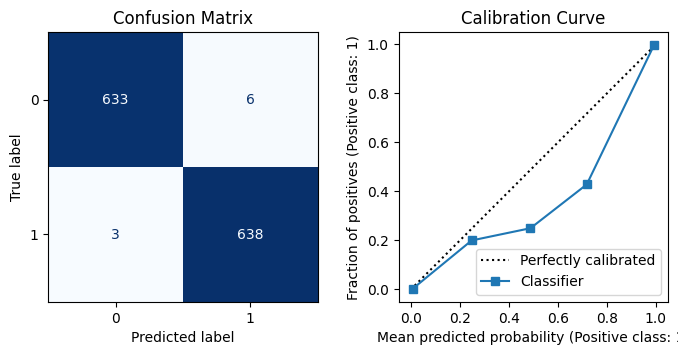

In [74]:
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
skmetrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=plt.cm.Blues, ax=ax1, colorbar=False)
ax1.set_title("Confusion Matrix")

ax2 = fig.add_subplot(gs[0,1])
skcalibration.CalibrationDisplay.from_predictions(
    y_true, y_proba[:,1], ax=ax2
)
ax2.set_title("Calibration Curve")
ax2.set_aspect('equal', adjustable='box')

fig.subplots_adjust(wspace=0.3)

In [75]:
del convnext

Interestingly, in this task the final model, which is the smallest, performs the best.

## Additional Resources

- Documentation for the Convolutional Layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Guide and discussion on optimisers - https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- CIFAR10 Tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- CNN implementation on CIFAR10 - https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844